# Insurance costs: exploratory and predictive analysis

This project uses a dataset from the book [Machine Learning with R](https://subscription.packtpub.com/search?query=machine%20learning%20r), by Brett Lantz. The dataset is of public domain, and can be found [here](https://github.com/stedy/Machine-Learning-with-R-datasets). 

The goal of this project is basically to explore this insurance costs data, looking for possible relationships between variables and making predictive machine learning models.

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

### Exploratory data analysis

In [59]:
insurance = pd.read_csv("data/insurance.csv")

display(insurance.head())
display(insurance.describe())
display(insurance.info())
display(insurance.isna().sum())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

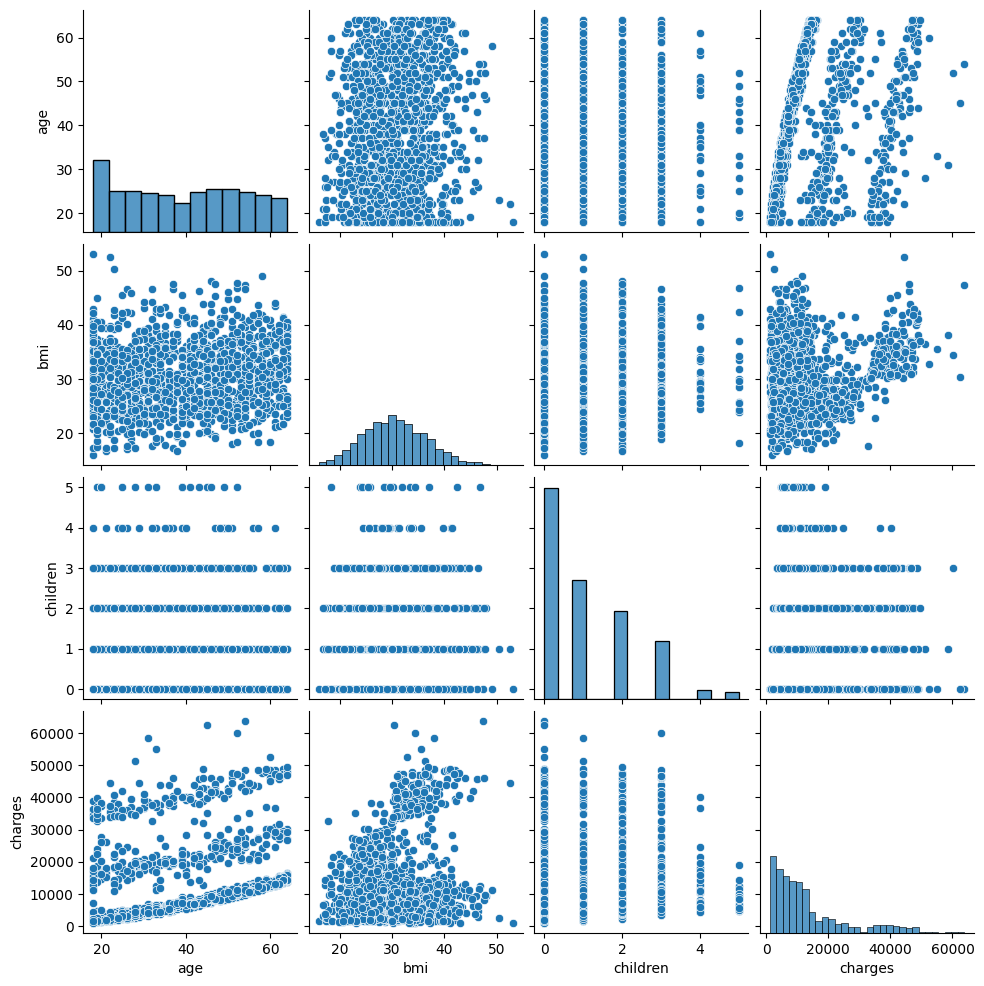

In [60]:
sns.pairplot(insurance)

Ok, this seems to be a very simple dataset, and the first thing we're gonna do is some quick feature engineering

In [61]:
# checking # of categories in categorical variables and looking for NAs before we create dummies:
for column in ['sex', 'children', 'smoker', 'region']:
    display(insurance[column].value_counts(dropna=False))

male      676
female    662
Name: sex, dtype: int64

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

no     1064
yes     274
Name: smoker, dtype: int64

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [62]:
insurance['female'] = (insurance['sex'] == 'female').astype(int)
insurance['has_children'] = (insurance['children'] > 0).astype(int)
insurance['smoker'] = (insurance['smoker'] == 'yes').astype(int)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,female,has_children
0,19,female,27.900,0,1,southwest,16884.92400,1,0
1,18,male,33.770,1,0,southeast,1725.55230,0,1
2,28,male,33.000,3,0,southeast,4449.46200,0,1
3,33,male,22.705,0,0,northwest,21984.47061,0,0
4,32,male,28.880,0,0,northwest,3866.85520,0,0


The main variable to be predicted in this dataset, of course, is __charges__.

So, we can start by ploting histograms:

Text(0.5, 1.0, 'Distribution of insurance charges (log)')

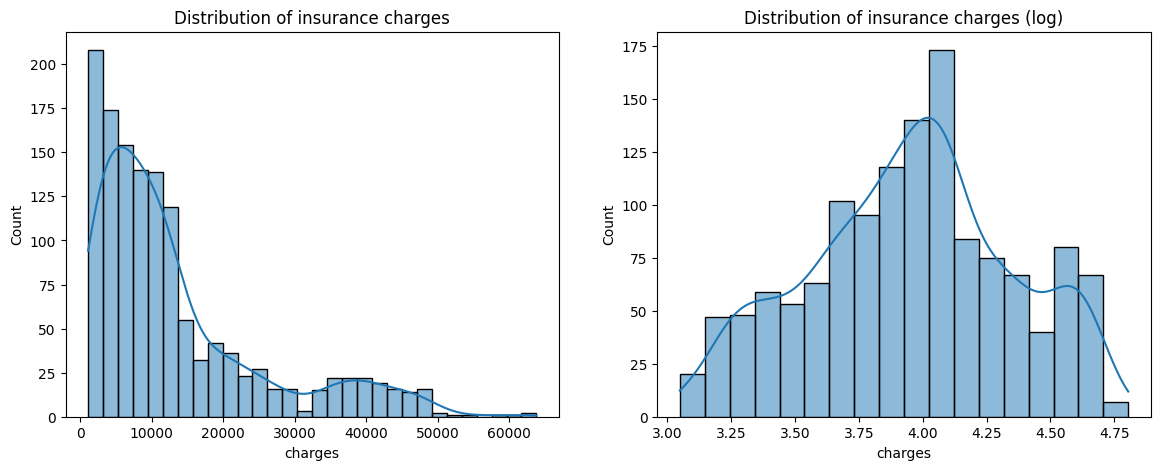

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# original scale
sns.histplot(insurance['charges'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of insurance charges')

# log scale
sns.histplot(np.log10(insurance['charges']), kde=True, ax=axes[1])
axes[1].set_title('Distribution of insurance charges (log)')


Before heading out to modeling, let's take a closer look at the relationship between some of the variables:

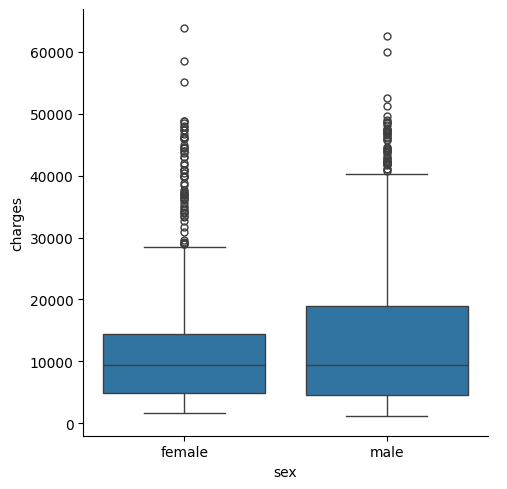

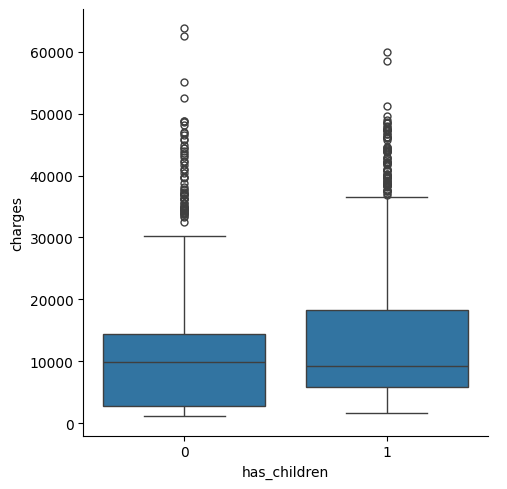

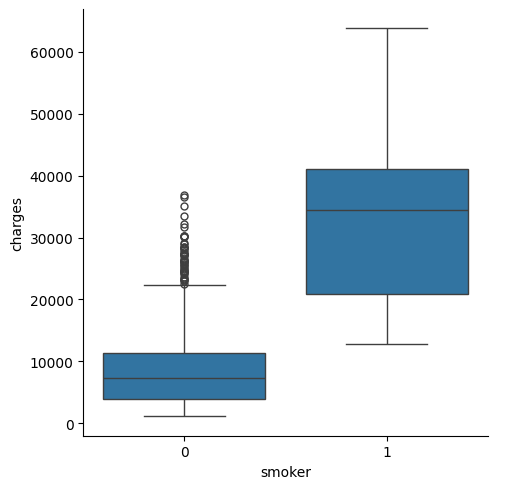

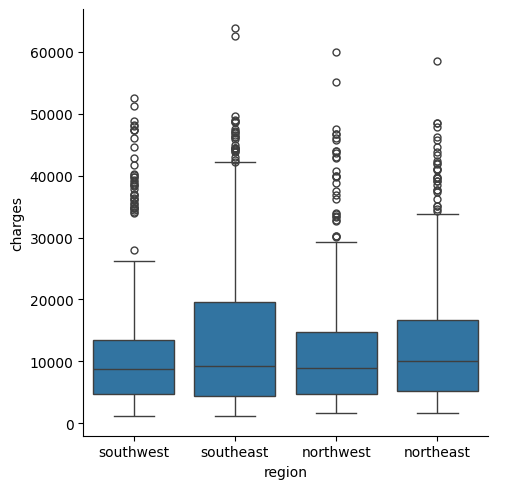

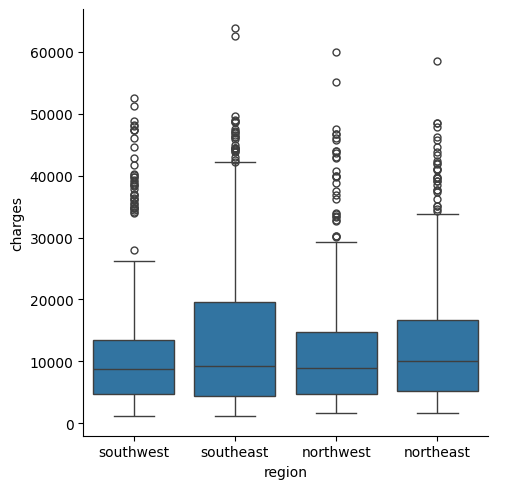

In [32]:
sns.catplot(data=insurance, x='sex', y='charges', kind='box')
sns.catplot(data=insurance, x='has_children', y='charges', kind='box')
sns.catplot(data=insurance, x='smoker', y='charges', kind='box')
sns.catplot(data=insurance, x='region', y='charges', kind='box')
sns.catplot(data=insurance, x='region', y='charges', kind='box')

Overall, there is a lot of outliers for all variables, but some key notes:
1) Men seems to be billed a little bit more than women, even though the median value is basically the same
2) Same logic for those with children
3) Smokers are charged way higher than non smokers
4) The median charge values seems to be pretty close for all regions, but the southeast and northeast regions do have a higher variation

Now, checking the relationship between the numerical variables, smoking seems to be a good predictor of higher charges:

<Axes: xlabel='age', ylabel='charges'>

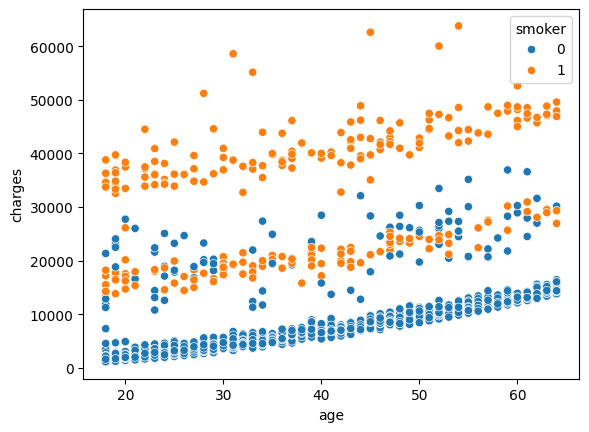

In [33]:
sns.scatterplot(data=insurance, x='age', y='charges', hue='smoker')

<Axes: xlabel='bmi', ylabel='charges'>

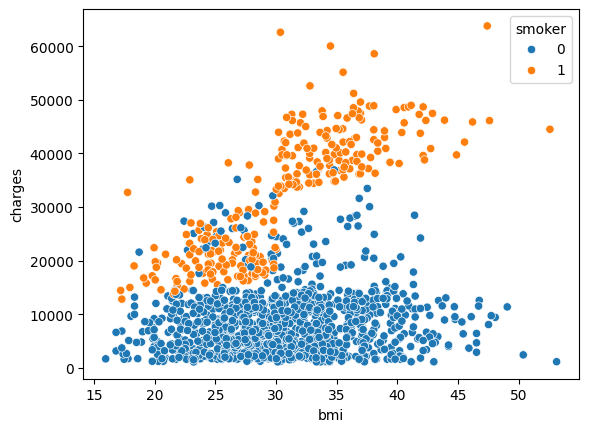

In [34]:
sns.scatterplot(data=insurance, x='bmi', y='charges', hue='smoker')

Diving deeper, there seems to be a cut-off for the smokers: if bmi (body mass index) is higher than 30, then the charges are higher.

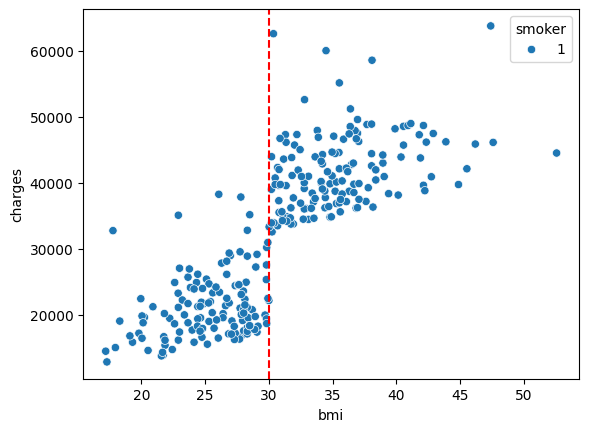

In [35]:
sns.scatterplot(data=insurance[insurance['smoker'] == 1], x='bmi', y='charges', hue='smoker')
plt.axvline(x=30, color='red', linestyle='--')

Checking out the classification of BMI values, accordingly to [WHO](https://www.who.int/europe/news-room/fact-sheets/item/a-healthy-lifestyle---who-recommendations), a BMI greater than 30 indicates Obesity class I.

This info reminds me of another variable that we can create, based on the BMI classification.

In [36]:
insurance['nutritional_status'] = pd.cut(
    insurance['bmi'],
    bins=[-np.inf, 18.5, 25, 30, 35, 40, np.inf],
    labels=['Underweight', 'Normal weight', 'Pre-obesity', 'Obesity class I', 'Obesity class II', 'Obesity class III'],
    right=False)

insurance['nutritional_status'].value_counts()


Obesity class I      391
Pre-obesity          386
Normal weight        225
Obesity class II     225
Obesity class III     91
Underweight           20
Name: nutritional_status, dtype: int64

<Axes: xlabel='charges', ylabel='nutritional_status'>

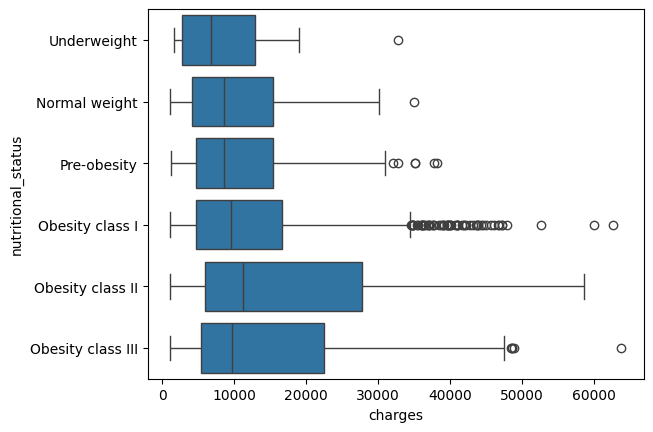

In [12]:
sns.boxplot(data=insurance, y='nutritional_status', x='charges')

Same scatterplot as before, but highlighting those with bmi >= 30:

<Axes: xlabel='age', ylabel='charges'>

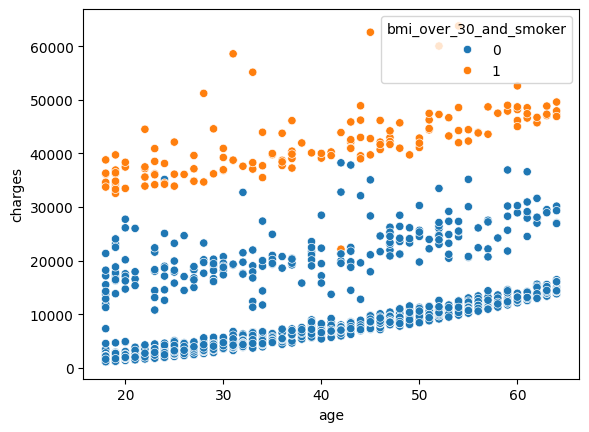

In [13]:
insurance['bmi_over_30'] = [1 if x >= 30 else 0 for x in insurance['bmi']]
insurance['bmi_over_30_and_smoker'] = insurance['bmi_over_30']*insurance['smoker']

sns.scatterplot(data=insurance, x='age', y='charges', hue='bmi_over_30_and_smoker')

The pattern seems to be that, for all ages, those who smoke AND have their body mass index over 30 are charged higher than others.

Looking closely at the blue dots, it is possible to see that they vary a little, but, in general, non smokers are charged less than smokers, regardless of their BMI. This trend implies that smoking is a significant factor in determining charges, although other characteristics are likely relevant as well.

In [14]:
insurance['bmi_and_smoker'] = np.select(
    [
        (insurance['bmi_over_30'] == 1) & (insurance['smoker'] == 1),
        (insurance['bmi_over_30'] == 1) & (insurance['smoker'] == 0),
        (insurance['bmi_over_30'] == 0) & (insurance['smoker'] == 1),
        (insurance['bmi_over_30'] == 0) & (insurance['smoker'] == 0)
        ],
        ['over30_smoker', 'over30_nonsmoker', 'under30_smoker', 'under30_nonsmoker']
)

insurance['bmi_and_smoker'].value_counts()

over30_nonsmoker     562
under30_nonsmoker    502
over30_smoker        145
under30_smoker       129
Name: bmi_and_smoker, dtype: int64

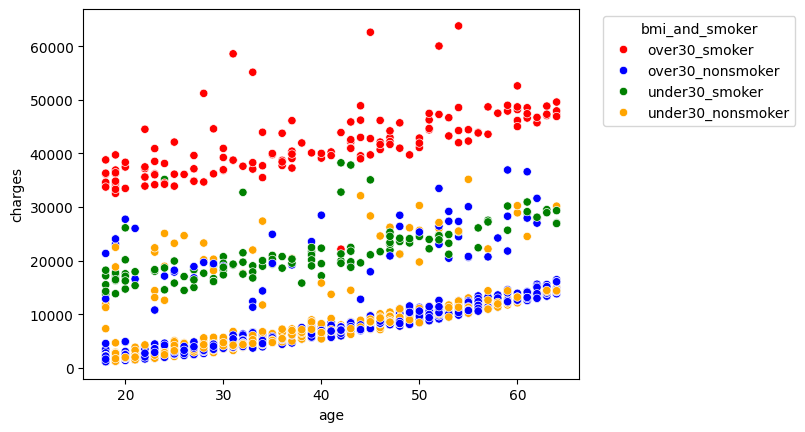

In [15]:
ax = sns.scatterplot(data=insurance, x='age', y='charges', hue='bmi_and_smoker',
                     hue_order = ['over30_smoker',
                                  'over30_nonsmoker',
                                  'under30_smoker',
                                  'under30_nonsmoker'],
                     palette={'over30_smoker': 'red',
                              'over30_nonsmoker': 'blue',
                              'under30_smoker': 'green',
                              'under30_nonsmoker': 'orange'})
sns.move_legend(ax, 'upper right', bbox_to_anchor=(1.45, 1))

## Inference modeling

Linear regressions are valuable tools for both inference and prediction. Before diving into predictive modeling, performing a quick linear regression can help us better understand the relationship between insurance costs and other variables while accounting for the influence of each factor. 

The model is

\begin{align*}
\log(\text{charges}) =&\ \beta_0
+ \beta_1 \times \text{age} 
+ \beta_2 \times \text{bmi} 
+ \beta_3 \times \text{children} 
+ \beta_4 \times \text{smoker} 
+ \beta_5 \times \text{female} \\
& + \beta_6 \times \text{region}_{\text{northwest}} 
+ \beta_7 \times \text{region}_{\text{southeast}} 
+ \beta_8 \times \text{region}_{\text{southwest}} 
+ \varepsilon
\end{align*}


In [25]:
results = smf.ols('np.log(charges) ~ age + bmi + children + smoker + female + region', data=insurance).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log(charges)   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     549.8
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        00:31:59   Log-Likelihood:                -808.52
No. Observations:                1338   AIC:                             1635.
Df Residuals:                    1329   BIC:                             1682.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.9551    

Overall, the OLS regression model provides a strong fit to the data, with an adjusted R-squared value of 0.767, indicating that approximately 76.7% of the variation in medical charges can be explained by the model's predictors.

The resulting equation is

\begin{align*}
\log(\text{charges}) =&\ 6.9551 + 0.0346 \times \text{age} 
+ 0.0139 \times \text{bmi} 
+ 0.1070 \times \text{children} 
+ 1.5437 \times \text{smoker} 
+ 0.0754 \times \text{female} \\
 & - 0.0638 \times \text{region}_{\text{northwest}} 
- 0.1572 \times \text{region}_{\text{southeast}} 
- 0.1290 \times \text{region}_{\text{southwest}} 
+ \varepsilon
\end{align*}

Such that:

- Age is positively associated with medical charges, with each additional year leading to an approximate 3.46% increase in charges. This makes sense, as older individuals generally require more medical care.

- BMI also shows a positive relationship with charges, with a 1.34% increase in charges for each unit increase in BMI. Higher BMI often correlates with health issues, which can lead to higher medical costs.

- Each additional child covered by the insurance increases charges by around 10.19%. More dependents likely mean more medical services are used.

- Smoking has a substantial impact on charges, leading to a 155.43% increase in costs compared to non-smokers. This is a significant finding, reflecting the well-known health risks and associated costs of smoking.

- Being female is associated with a modest 7.5% increase in charges. This could be due to differences in healthcare usage between genders.

- Geographical Region also plays a role, with individuals in the Southeast and Southwest regions experiencing lower charges compared to those in the Northeast, though the results for the Northwest region are not statistically significant.

## Predictive modeling